## **Configuracion Inicial**

In [14]:
rm(list=ls())

require(pacman)

p_load("dplyr",
       "tidyverse",
       "rugarch",
       "readxl",
       "xts",
       "ggplot2",
       "stargazer",
       "scales")

if (tail(strsplit(getwd(), "/")[[1]], n = 1) == "scripts") {
  setwd("..")
}

getwd()


[1] "c:/Users/NicolasLozano/OneDrive - Universidad de los andes/UNIVERSIDAD/9. NOVENO SEMESTRE/SERIES DE TIEMPO/TALLERES/202510-Series-Taller2"

## **Cargue y preparacion de datos**

In [15]:
trm  <- read_excel("data\\TRM.xlsx")

trm  <- trm %>% rename(
                        fecha = `Fecha (dd/mm/aaaa)`,
                        trm = `Tasa de cambio representativa del mercado (TRM)`
                        )

trm$fecha <- as.Date(trm$fecha)

trm  <- trm[order(trm$fecha),]

trm <- trm %>%
  mutate(fecha = format(fecha, "%Y-%m")) %>%
  group_by(fecha) %>%
  summarise(trm = mean(trm, na.rm = TRUE))  %>% 
  ungroup()

trm  <- trm %>% mutate(
                        retorno = 100*(log(trm)-log(lag(trm,1)))
                        )

trm  <- na.omit(trm)

mean(trm$retorno, na.omit = TRUE)


[1] 0.4712121

## **2.f. Dinámicas de varianza (parte 2)**

In [16]:
model_spec  <- ugarchspec(
                          variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), # nolint: line_length_linter.
                          mean.model = list(armaOrder = c(0, 1), include.mean = TRUE),  # nolint: line_length_linter.
                          distribution.model = "norm"
                        )

model  <- ugarchfit(spec = model_spec, data = trm$retorno)

show(model)

resid <-  residuals(model)

var  <- sigma(model)

resid_std  <-  resid / sqrt(var)

resid_std2  <- resid_std^2

trm$resid_std  <- coredata(resid_std)

trm$resid_std2  <- coredata(resid_std2)

head(trm)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu       0.49753    0.160505   3.0998 0.001936
ma1      0.37352    0.048058   7.7723 0.000000
omega    0.32184    0.154241   2.0866 0.036925
alpha1   0.16421    0.046001   3.5697 0.000357
beta1    0.80766    0.046482  17.3758 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu       0.49753    0.178561   2.7863 0.005331
ma1      0.37352    0.049221   7.5887 0.000000
omega    0.32184    0.166519   1.9327 0.053269
alpha1   0.16421    0.058355   2.8140 0.004893
beta1    0.80766    0.049449  16.3332 0.000000

LogLikelihood : -938.5501 

Information Criteria
------------------------------------
               

fecha,trm,retorno,resid_std,resid_std2
<chr>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
1992-01,644.0581,2.141439,0.9944087,0.9888486
1992-02,635.6717,-1.310661,-1.5001113,2.2503338
1992-03,640.5019,0.756987,0.7215977,0.5207032
1992-04,649.9550,1.465099,0.3401329,0.1156904
1992-05,659.7713,1.499012,0.5307181,0.2816617
1992-06,677.1653,2.602221,1.2291380,1.5107802


## **2.g. Verificar que el modelo captura las dinamicas**

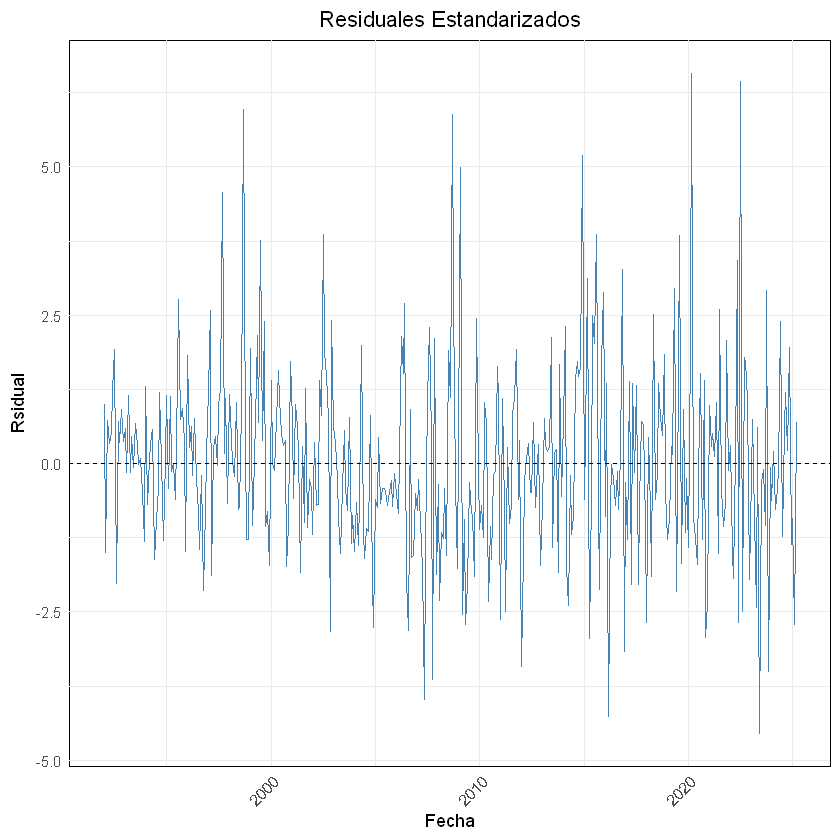

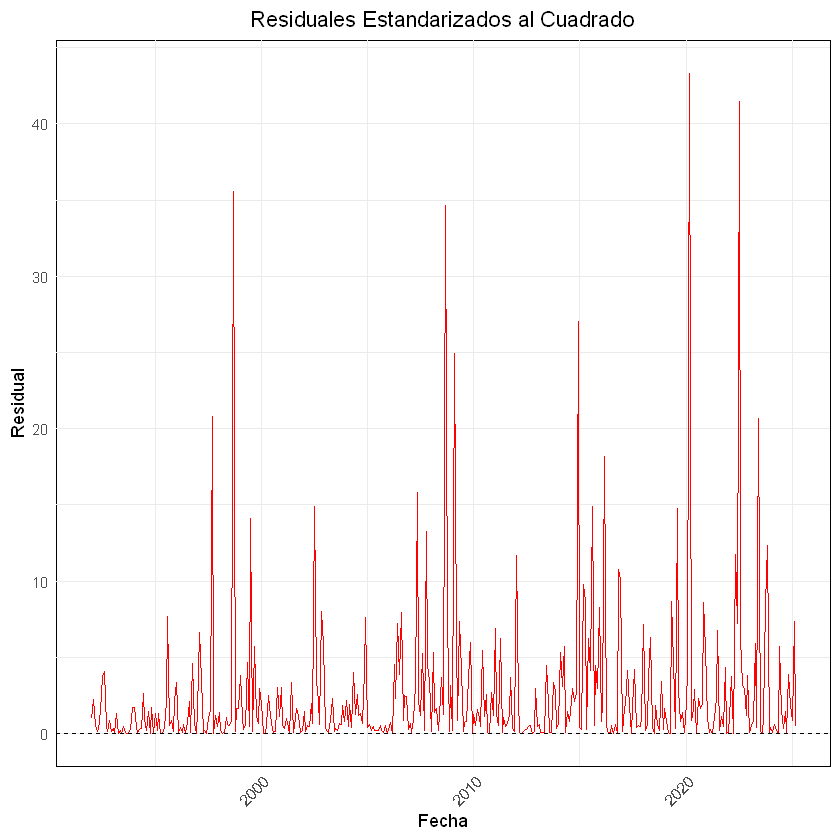

In [17]:
trm$fecha <- as.Date(paste0(trm$fecha, "-01"))

plot  <-  ggplot(trm, aes(x = fecha, y = resid_std,group=1)) +
  geom_line(color = "steelblue") +
  labs(title = "Residuales Estandarizados", x = "Fecha", y = "Rsidual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#000000") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )
plot

ggsave("output\\graf_resistd.png", plot = plot, width = 8, height = 6, dpi = 300)

plot  <-  ggplot(trm, aes(x = fecha, y = resid_std2,group=1)) +
  geom_line(color = "#ff0000") +
  labs(title = "Residuales Estandarizados al Cuadrado", x = "Fecha", y = "Residual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#000000") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )

plot

ggsave("output\\graf_resistd2.png", plot = plot, width = 8, height = 6, dpi = 300)

In [18]:
lags <- c(5, 10, 15)

results <- lapply(lags, function(lag_val) {
  test <- Box.test(trm$resid_std2, lag = lag_val, type = "Ljung-Box")
  data.frame(
    Rezago = lag_val,
    `Estadistico` = test$statistic,
    p_valor = test$p.value
  )
})


df_q_test <- do.call(rbind, results)

rownames(df_q_test) <- NULL

df_q_test

latex_txt  <- stargazer(as.matrix(df_q_test), summary = FALSE, rownames = FALSE, type = "latex", label = "tab:q_residstd2",title = "Prueba Q para Residuales Estandarizados al Cuadrado")


latex_txt <- gsub(
  pattern = "^\\\\begin\\{table\\}\\[!htbp\\] \\\\centering",
  replacement = "\\\\begin{table}[H] \\\\centering",
  x = latex_txt
)

writeLines(latex_txt, "output\\q_resid2.tex")


Rezago,Estadistico,p_valor
<dbl>,<dbl>,<dbl>
5,3.768133,0.5832582
10,8.231610,0.6062250
15,13.362952,0.5742857



% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: dom, abr 06, 2025 - 20:04:08
\begin{table}[!htbp] \centering 
  \caption{Prueba Q para Residuales Estandarizados al Cuadrado} 
  \label{tab:q_residstd2} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Rezago & Estadistico & p\_valor \\ 
\hline \\[-1.8ex] 
$5$ & $3.768$ & $0.583$ \\ 
$10$ & $8.232$ & $0.606$ \\ 
$15$ & $13.363$ & $0.574$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


# **2.h Pronostico 1 paso adelante**

In [19]:
fcast_1h  <- ugarchforecast(model, n.ahead = 1)

retorno <- fitted(fcast_1h)

varianza  <- sigma(fcast_1h)^2

df_pronostico  <- data.frame(
    Retorno = retorno,
    Varianza = varianza
  )
colnames(df_pronostico)  <- c("Retorno", "Varianza")
rownames(df_pronostico) <- NULL

df_pronostico

latex_txt  <- stargazer(
  as.matrix(df_pronostico),
  summary = FALSE,
  rownames = FALSE, type = "latex",
  label = "tab:1_step",
  title = "Pron\\'ostico 1 Paso Adelante")

latex_txt <- gsub(
  pattern = "^\\\\begin\\{table\\}\\[!htbp\\] \\\\centering",
  replacement = "\\\\begin{table}[H] \\\\centering",
  x = latex_txt
)

writeLines(latex_txt, "output\\1h_forcast.tex")

Retorno,Varianza
<dbl>,<dbl>
0.9349917,6.963253



% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: dom, abr 06, 2025 - 20:04:08
\begin{table}[!htbp] \centering 
  \caption{Pron\'ostico 1 Paso Adelante} 
  \label{tab:1_step} 
\begin{tabular}{@{\extracolsep{5pt}} cc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Retorno & Varianza \\ 
\hline \\[-1.8ex] 
$0.935$ & $6.963$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


# **2.i. Simulaciones**

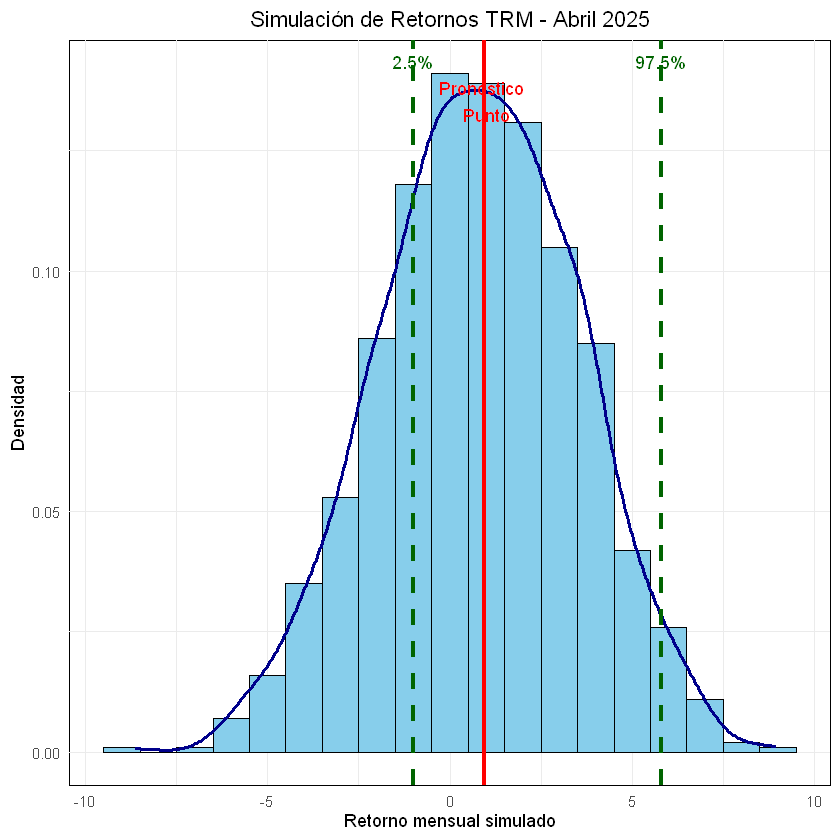

In [20]:
sim <- ugarchsim(model, n.sim = 1, m.sim = 1000, startMethod = "sample")

retornos  <- fitted(sim)[1,]

sim_df <- data.frame(retornos = retornos)

ic  <- quantile(retornos, probs = c(0.25, 0.975))

media  <- mean(retornos)

plot <- ggplot(sim_df, aes(x = retornos)) +
  geom_histogram(aes(y = ..density..), binwidth = 1, fill = "skyblue", color = "black",) +
  geom_density(color = "darkblue", size = 1) +
  geom_vline(xintercept = retorno,
             color = "red",
             linetype = "solid",
             size = 1.2) +
  geom_vline(xintercept = ic,
             color = "darkgreen",
             linetype = "dashed",
             size = 1.2) +
  labs(title = "Simulación de Retornos TRM - Abril 2025",
       x = "Retorno mensual simulado",
       y = "Densidad") +
  annotate("text",
           x = retorno,
           y = Inf,
           label = "Pronostico \n Punto",
           vjust = 2,
           color = "red") +
  annotate("text",
           x = ic[1],
           y = Inf,
           label = "2.5%",
           vjust = 2,
           color = "darkgreen") +
  annotate("text",
           x = ic[2],
           y = Inf,
           label = "97.5%",
           vjust = 2,
           color = "darkgreen") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )
plot
ggsave("output\\hist_sim.png", plot = plot, width = 8, height = 6, dpi = 300)

# **2.j PyG**

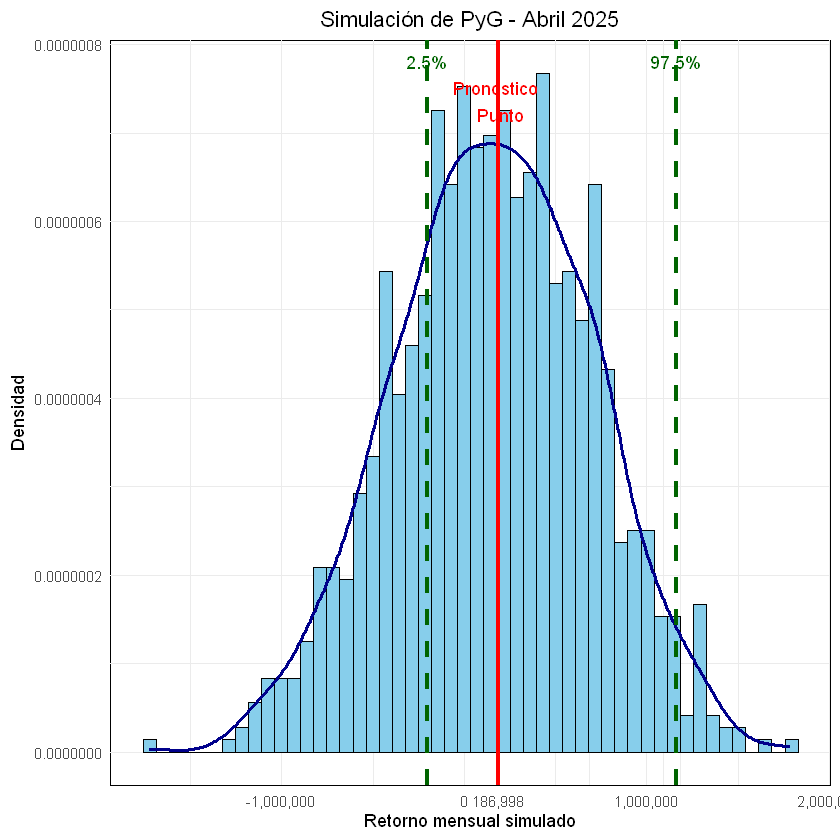

In [25]:
#options(scipen=999)
sim_df2  <- data.frame(
  retornos= (sim_df$retornos / 100) * 20000000
)

p_punto  <- (retorno / 100) * 20000000

ic  <- quantile(sim_df2$retornos, probs = c(0.25, 0.975))

media  <- mean(sim_df2$retornos)

plot <- ggplot(sim_df2, aes(x = retornos)) +
  geom_histogram(aes(y = ..density..), bins = 50, fill = "skyblue", color = "black",) +
  geom_density(color = "darkblue", size = 1) +
  geom_vline(xintercept = p_punto,
             color = "red",
             linetype = "solid",
             size = 1.2) +
  geom_vline(xintercept = ic,
             color = "darkgreen",
             linetype = "dashed",
             size = 1.2) +
  labs(title = "Simulación de PyG - Abril 2025",
       x = "Retorno mensual simulado",
       y = "Densidad") +
  annotate("text",
           x = p_punto,
           y = Inf,
           label = "Pronostico \n Punto",
           vjust = 2,
           color = "red") +
  annotate("text",
           x = ic[1],
           y = Inf,
           label = "2.5%",
           vjust = 2,
           color = "darkgreen") +
  annotate("text",
           x = ic[2],
           y = Inf,
           label = "97.5%",
           vjust = 2,
           color = "darkgreen") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )+
  scale_x_continuous(
    breaks = c(pretty(sim_df2$retornos), p_punto),
    labels = comma)
plot
ggsave("output\\hist_sim_pg.png", plot = plot, width = 8, height = 6, dpi = 300)
